# Molecular dynamics simulations

Classical molecular dynamics simulations involve numerically integrating Newton's equations of motion for $N$ particles interacting through a pair potential $V(\mathbf{r}_1,\mathbf{r}_2)$:
$$
m_i \ddot{\mathbf{r}}_i = - \sum_{j \neq i} \nabla_i V(\mathbf{r}_i,\mathbf{r}_j)~.
$$

If the system is sufficiently large, one can use MD simulations to study its macroscopic (thermodynamic) properties such as the dependence of the pressure on temperature and density -- the equation of state.

In many case the pair potential depends only on the distance $r_{ij} = |\mathbf{r}_i - \mathbf{r}_j|$.
In this case the equations of motion read
$$
m_i \ddot{\mathbf{r}}_i = - \sum_{j \neq i} \frac{d V(r_{ij})}{d r_{ij}} \, \frac{\mathbf{r}_i - \mathbf{r}_j}{r_{ij}}~.
$$

## Lennard-Jones fluid

Lennard-Jones fluid corresponds to a pair potential
$$
V_{LJ}(r) = 4 \varepsilon \left[ (\sigma/r)^{12} - (\sigma/r)^6 \right].
$$

The Lennard-Jones system has a rich phase diagram containing various phases (gas, liquid, solid) and the associated phase transitions.

![LJPD](LJ_phase_diagram.gif)

To evaluate the properties of the LJ fluid, one would run molecular dynamics simulations for sufficiently long time to let the system equilibrate, and calculate its macroscopic properties like pressure as time average. The simulations are typically performed in a box with periodic boundary conditions to minimize finite-size effects.

## Velocity Verlet method

For long molecular dynamics simulations it makes sense to use stable, time-reversal numerical schemes that conserve energy. The leapfrog method is a good choice. When applied to Newton's equations of motion it is know as Verlet method.

Suppose we are solving Newton's equations of motion
$$
\frac{d^2 x}{dt^2} = f(x,t).
$$
These are rewritten as
\begin{align*}
\frac{dx}{dt} &= v, \\
\frac{dv}{dt} &= f(x,t).
\end{align*}

If we apply the leapfrog scheme to this system of equations, it will look like
\begin{align*}
x(t+h) & = x(t) + h v(t + h/2), \\
v(t+3h/2) &= v(t+h/2) + h f[x(t+h), t+h)],
\end{align*}
i.e. the coordinates are evaluated are full steps using velocity estimates at half-steps,
and vice versa.

This is the essence of the Verlet method.
It's feature is that we do not need to keep track of coordinates at half-steps (only the velocities) and of velocities at full steps. In case we are interested in velocity values also at full step, these can be estimated as $v(t+h) = v(t+h/2) + (h/2) f[x(t+h),t+h]$.

The full algorithm is as follows. Given initial values $x(t)$ and $v(t)$ one first computes
$$
v(t+h/2) = v(t) + \frac{h}{2} f[x(t),t].
$$
Then each step of the Verlet algorithm corresponds to
\begin{align*}
v(t+h/2) & = v(t) + \frac{h}{2} f[x(t),t],\\
x(t+h) & = x(t) + h v(t+h/2), \\
v(t+h) & = v(t+h/2) + \frac{h}{2} f[x(t+h),t+h)].
\end{align*}

The algorithm is straightforwardly generalizable to more than one variable.

Let us first write a code for integrating Newton's equations of motion for arbitrary central potential

In [1]:
import numpy as np

# Simulation parameters (can be changed later)
n_particles = 125      # Number of particles
density     = 0.8      # Density of the fluid
box_length = (n_particles/density)**(1/3.)  # Length of simulation box (determined by the number of particles and density)
temperature0 = 1.0    # Initial (desired) temperature of the system
time_step = 0.004     # Time step for the simulation
num_steps = 1000      # Number of simulation steps


# Initialization
# Initial position at the nodes of the cube
# Helps to avoid particle overlap
def initial_positions():
    ret = np.zeros((n_particles,3))
    Nsingle = np.ceil(n_particles**(1/3.))
    dL = box_length / Nsingle
    for i in range(n_particles):
        ix = i % Nsingle
        iy = (np.trunc(i / Nsingle)) % Nsingle
        iz = np.trunc(i / (Nsingle * Nsingle))
        ret[i][0] = (ix + 0.5) * dL;
        ret[i][1] = (iy + 0.5) * dL;
        ret[i][2] = (iz + 0.5) * dL;
    return ret

# Computes forces for a given vector of positions, interaction potential and its gradient
# Return a tuple: positions, total potential energy, and the virial part of the pressure
def compute_forces(forces, positions, potential, potential_gradient):
    # forces = np.zeros_like(positions)
    forces.fill(0.)
    potential_energy = 0.0
    virial = 0.0
    for i in range(n_particles):
        for j in range(i+1, n_particles):
            # Vector of relative distance
            r_ij = positions[i] - positions[j]
            # Periodic boundary conditions (minimum-image convention)
            r_ij = r_ij - box_length*np.round(r_ij/box_length)
            
            r_sq = np.sum(r_ij**2)
            f_ij = -potential_gradient(r_sq) * r_ij
            
            forces[i] += f_ij
            forces[j] -= f_ij
            potential_energy += potential(r_sq)
            virial += np.dot(f_ij, r_ij)
            
    virial = virial/(3.0*box_length**3)
    return forces, potential_energy, virial


# Compute the kinetic temperature from velocities (kinetic energy) 
def compute_kinetic_temperature(velocities):
    return np.sum(velocities**2) / 3. / n_particles

# Renormalize the velocities to match the desired kinetic temperature 
def renormalize_velocities(velocities, temperature = temperature0):
    Tkin = compute_kinetic_temperature(velocities)
    factor = np.sqrt(temperature / Tkin)
    velocities *= factor


# Apply the velocity verlet time step
# Returns the tuple of new positions, velocities, accelerations (forces), potential energy and pressure
def velocity_verlet(positions, velocities, accelerations, 
                    time_step, potential, potential_gradient):
    # Update positions
    positions += velocities*time_step + 0.5*accelerations*time_step**2
    positions = positions - box_length*np.floor(positions/box_length)
    # Update velocities
    velocities_half = velocities + 0.5*accelerations*time_step
    # Compute new forces and potential energy
    accelerations, potential_energy, pressure = compute_forces(accelerations, positions, potential, potential_gradient)
    # Update velocities using new accelerations
    velocities = velocities_half + 0.5*accelerations*time_step
    # Add ideal gas contribution to the pressure
    kinetic_temperature = compute_kinetic_temperature(velocities)
    pressure += density * kinetic_temperature
    return positions, velocities, accelerations, potential_energy, pressure


Now the Lennard-Jones potential properties

In [2]:
# Lennard-Jones potential as a function of squared distance
def lj_potential(r_sq):
    r6 = r_sq**3
    r12 = r6**2
    return 4.0*(1./r12 - 1./r6)

# The grandient term dV/dr / r in the rhs of Newton's equations
# for the LJ potential
def lj_potential_gradient(r_sq):
    r6 = r_sq**3
    r12 = r6**2
    return -24.0*(2./r12 - 1./r6) / r_sq

Perform the simulation

<IPython.core.display.Javascript object>

1.5   -0.15894785673871592   1.341052143261284   1.0   -0.3154156116256416
1.5001250585003958   -0.1590999169911537   1.341025141509242   1.0000833723335971   0.6843144906016024
2.009401459812359   -0.6689102670272136   1.3404911927851453   1.3396009732082392   0.7363639160460876
2.013022717317429   -0.6724091986808614   1.3406135186365675   1.342015144878286   0.9493807104749248
2.0389123523092283   -0.6979230394673545   1.3409893128418737   1.3592749015394856   0.8654212925803128
1.928206554780497   -0.587329086144571   1.340877468635926   1.2854710365203312   0.7916701524909756
2.0752720659009753   -0.7348979759991814   1.340374089901794   1.3835147106006502   0.7916801212974813
1.9969120317284077   -0.6556777115638882   1.3412343201645194   1.3312746878189385   1.1413090865195477
2.078193364972193   -0.7371386891655621   1.3410546758066308   1.3854622433147954   0.6438112418496416
2.0999474060307337   -0.7593977198569153   1.3405496861738184   1.3999649373538225   0.605578849107362

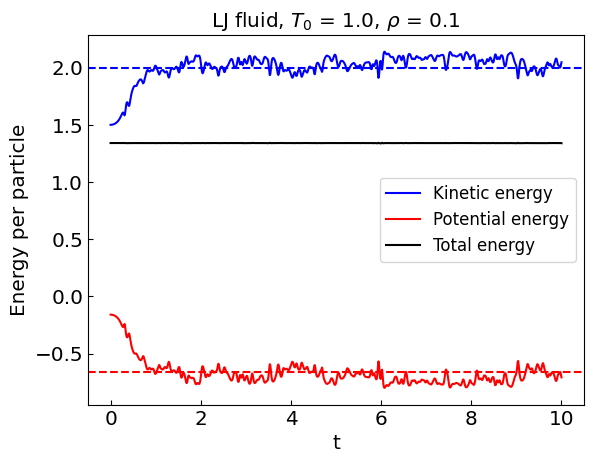

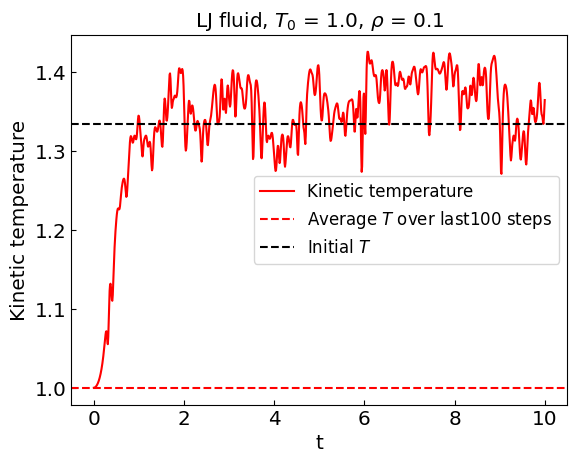

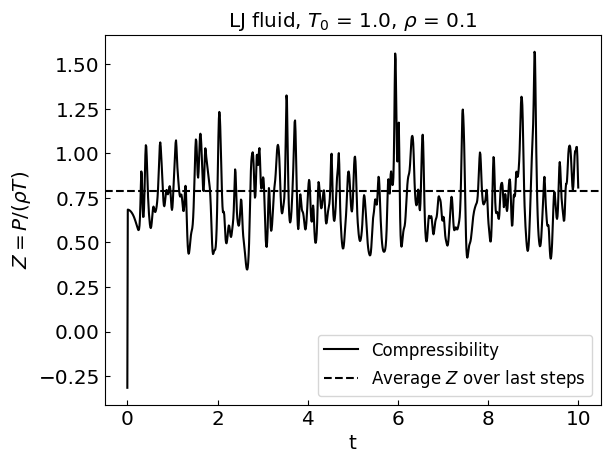

In [3]:
# Simulation parameters
n_particles = 64       # Number of particles
density     = 0.1      # Density of the fluid
box_length = (n_particles/density)**(1/3.)  # Length of simulation box (determined by the number of particles and density)
temperature0 = 1.0     # Initial (desired) temperature of the system
time_step = 0.01       # Time step for the simulation
num_steps = 1000       # Number of simulation steps

averaging_steps = 100  # Number of steps to compute time average over at the end


# Initial conditions
positions = initial_positions()
velocities = np.random.normal(loc=0.0, scale=np.sqrt(temperature0), size=(n_particles, 3))
accelerations = np.zeros((n_particles, 3))
t = 0

renormalize_velocities(velocities, temperature0)
accelerations, potential_energy, pressure = compute_forces(accelerations, positions, lj_potential, lj_potential_gradient)
kinetic_energy = 0.5*np.sum(velocities**2)
total_energy = potential_energy + kinetic_energy
temperature = temperature0


# Visualization
from vpython import *

show_animation = False
if show_animation:
    scene = canvas() # This is needed in Jupyter notebook and lab to make programs easily rerunnable
    cube = [
        curve(vector(- 0.5*box_length,- 0.5*box_length,- 0.5*box_length), 
              vector(0.5*box_length,- 0.5*box_length,- 0.5*box_length)),
        curve(vector(- 0.5*box_length,- 0.5*box_length,- 0.5*box_length), 
              vector(-0.5*box_length,0.5*box_length,- 0.5*box_length)),
        curve(vector(0.5*box_length,- 0.5*box_length,- 0.5*box_length), 
              vector(0.5*box_length,0.5*box_length,-0.5*box_length)),
        curve(vector(-0.5*box_length, 0.5*box_length,- 0.5*box_length), 
              vector(0.5*box_length,  0.5*box_length,- 0.5*box_length)),
        curve(vector(-0.5*box_length,- 0.5*box_length,0.5*box_length), 
              vector(0.5*box_length,-0.5*box_length, 0.5*box_length)),
        curve(vector(-0.5*box_length, -0.5*box_length,0.5*box_length), 
              vector(-0.5*box_length,0.5*box_length,0.5*box_length)),
        curve(vector(0.5*box_length, -0.5*box_length,0.5*box_length), 
              vector(0.5*box_length,0.5*box_length, 0.5*box_length)),
        curve(vector(-0.5*box_length, 0.5*box_length,0.5*box_length), 
              vector(0.5*box_length,0.5*box_length, 0.5*box_length)),
        curve(vector(- 0.5*box_length,- 0.5*box_length,- 0.5*box_length), 
              vector(-0.5*box_length,- 0.5*box_length,0.5*box_length)),
        curve(vector(0.5*box_length,- 0.5*box_length,- 0.5*box_length), 
              vector(0.5*box_length,- 0.5*box_length,0.5*box_length)),
        curve(vector(- 0.5*box_length, 0.5*box_length,- 0.5*box_length), 
              vector(-0.5*box_length, 0.5*box_length,0.5*box_length)),
        curve(vector(0.5*box_length,0.5*box_length,- 0.5*box_length), 
              vector(0.5*box_length,0.5*box_length,0.5*box_length))
    ]
    spheres = [sphere(pos=vector(pos[0] - 0.5*box_length,pos[1] - 0.5*box_length,pos[2] - 0.5*box_length),radius=0.1,color=color.orange) for pos in positions]
    fps = 60

times = []
kinetic_energies = []
potential_energies = []
total_energies = []
temperatures = []
compressibilities = []

times.append(t)
kinetic_energies.append(kinetic_energy / n_particles)
potential_energies.append(potential_energy / n_particles)
total_energies.append(total_energy / n_particles)
temperatures.append(temperature)
compressibilities.append(pressure / (temperature * density))

print(kinetic_energy / n_particles," ",
      potential_energy / n_particles," ",
      total_energy / n_particles, " ", 
      temperature, " ", 
      pressure / (temperature * density))

# Main loop
for step in range(num_steps):
    # Perform Velocity Verlet integration
    positions, velocities, accelerations, potential_energy, pressure = velocity_verlet(positions, velocities, accelerations, time_step, lj_potential, lj_potential_gradient)
    # Compute kinetic energy
    kinetic_energy = 0.5*np.sum(velocities**2)
    # Compute total energy
    total_energy = potential_energy + kinetic_energy
    # Compute temperature and pressure
    temperature = 2.0*kinetic_energy/(3.0*n_particles)
    # Update time
    t += time_step
    
    if show_animation:
        rate(fps)
        for i in range(n_particles):
            spheres[i].pos = vector(positions[i][0] - 0.5*box_length,positions[i][1] - 0.5*box_length,positions[i][2] - 0.5*box_length)
    
    
    times.append(t)
    kinetic_energies.append(kinetic_energy / n_particles)
    potential_energies.append(potential_energy / n_particles)
    total_energies.append(total_energy / n_particles)
    temperatures.append(temperature)
    compressibilities.append(pressure / (temperature * density))
    
    # Print results
    if step % 100 == 0:
        print(kinetic_energy / n_particles," ",
              potential_energy / n_particles," ",
              total_energy / n_particles, " ", 
              temperature, " ", 
              pressure / (temperature * density))
        

# Plot the energies
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'xtick.direction':'in',
         'ytick.direction':'in',
         }
plt.rcParams.update(params)

# Averages over last averaging_steps steps
Kav = np.sum(kinetic_energies[-averaging_steps:])/averaging_steps
Vav = np.sum(potential_energies[-averaging_steps:])/averaging_steps
Tav = np.sum(temperatures[-averaging_steps:])/averaging_steps
Zav = np.sum(compressibilities[-averaging_steps:])/averaging_steps


plt.plot(times, kinetic_energies, label = 'Kinetic energy', color = 'blue')
plt.axhline(y = Kav, linestyle = '--', color = 'blue')
plt.plot(times, potential_energies, label = 'Potential energy', color = 'red')
plt.axhline(y = Vav, linestyle = '--', color = 'red')
plt.plot(times, total_energies, label = 'Total energy', color = 'black')
plt.xlabel('t')
plt.ylabel('Energy per particle')
plt.title("LJ fluid, ${T_0}$ = " + str(temperature0) + ", ${\\rho}$ = " + str(density))
plt.legend()
plt.show()

plt.plot(times, temperatures, label = 'Kinetic temperature', color = 'red')
plt.axhline(y = temperature0, color = 'red', linestyle = '--', label = 'Average ${T}$ over last' + str(averaging_steps) + ' steps')
plt.axhline(y = Tav, linestyle = '--', color = 'black', label = 'Initial ${T}$')
plt.xlabel('t')
plt.ylabel('Kinetic temperature')
plt.title("LJ fluid, ${T_0}$ = " + str(temperature0) + ", ${\\rho}$ = " + str(density))
plt.legend()
plt.show()

plt.plot(times, compressibilities, label = 'Compressibility', color = 'black')
plt.axhline(y = Zav, linestyle = '--', color = 'black', label = 'Average ${Z}$ over last steps')
plt.xlabel('t')
plt.ylabel('${Z = P/(\\rho T)}$')
plt.title("LJ fluid, ${T_0}$ = " + str(temperature0) + ", ${\\rho}$ = " + str(density))
plt.legend()
plt.show()


To keep the temperature fixed we can renormalize the velocities periodically during the equilibration stage

1.5   -0.15894785673871592   1.341052143261284   1.0   -0.3154156116256416
1.5   -0.15907520827652416   1.340924791723476   1.0   0.6844054500225077
1.5   -0.48668517932301475   1.0133148206769853   1.0   0.8105246964701448
1.5   -0.6314528786759385   0.8685471213240615   1.0   0.7767079282681939
1.5   -0.7658716702536369   0.7341283297463631   1.0   0.9007250206854378
1.5   -0.7982653011865533   0.7017346988134467   1.0   0.6736007325822067
1.4539365891795772   -0.734654694954178   0.7192818942253992   0.9692910594530515   0.7320824711905355
1.6433919406246558   -0.9254733042949713   0.7179186363296844   1.0955946270831038   0.9750854713005237
1.5807177557962429   -0.860614955591448   0.7201028002047949   1.0538118371974952   1.0341736857786192
1.5547558130972559   -0.834699442150298   0.7200563709469578   1.0365038753981706   0.9061797682292063
1.4372341599916174   -0.7174798305734449   0.7197543294181725   0.9581561066610783   0.22375647066826002


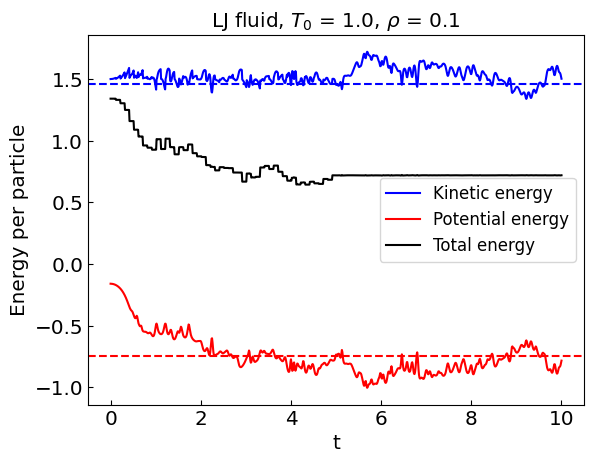

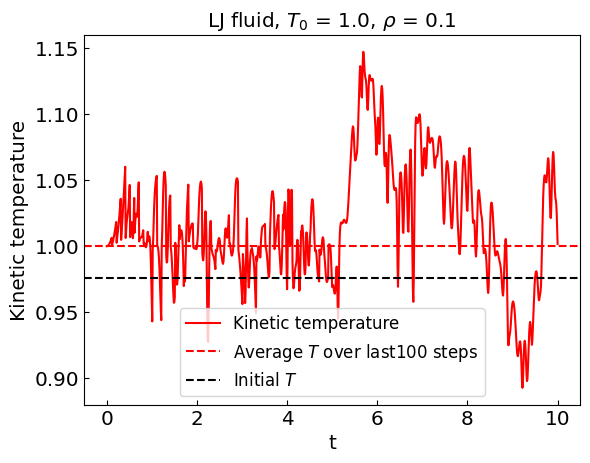

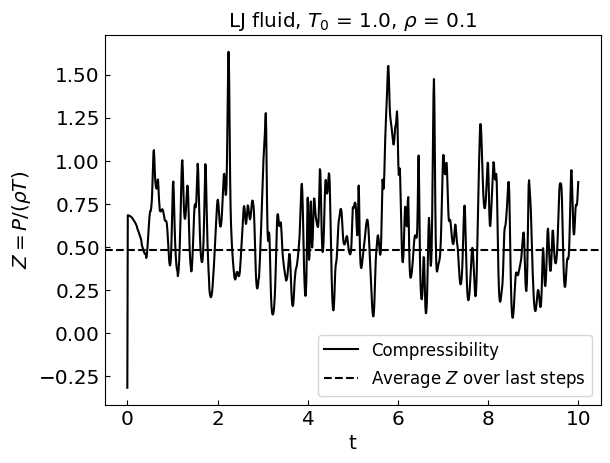

In [4]:
# Simulation parameters
n_particles = 64      # Number of particles
density     = 0.1      # Density of the fluid
box_length = (n_particles/density)**(1/3.)  # Length of simulation box (determined by the number of particles and density)
temperature0 = 1.0    # Initial (desired) temperature of the system
time_step = 0.01      # Time step for the simulation
num_steps = 1000       # Number of simulation steps
equilbration_steps = 500 # Number of equilibration steps

# Initial conditions
positions = initial_positions()
velocities = np.random.normal(loc=0.0, scale=np.sqrt(temperature0), size=(n_particles, 3))
accelerations = np.zeros((n_particles, 3))
t = 0

renormalize_velocities(velocities, temperature0)
accelerations, potential_energy, pressure = compute_forces(accelerations, positions, lj_potential, lj_potential_gradient)
kinetic_energy = 0.5*np.sum(velocities**2)
total_energy = potential_energy + kinetic_energy
temperature = temperature0

show_animation = False
if show_animation:
    scene = canvas() # This is needed in Jupyter notebook and lab to make programs easily rerunnable
    cube = [
        curve(vector(- 0.5*box_length,- 0.5*box_length,- 0.5*box_length), 
              vector(0.5*box_length,- 0.5*box_length,- 0.5*box_length)),
        curve(vector(- 0.5*box_length,- 0.5*box_length,- 0.5*box_length), 
              vector(-0.5*box_length,0.5*box_length,- 0.5*box_length)),
        curve(vector(0.5*box_length,- 0.5*box_length,- 0.5*box_length), 
              vector(0.5*box_length,0.5*box_length,-0.5*box_length)),
        curve(vector(-0.5*box_length, 0.5*box_length,- 0.5*box_length), 
              vector(0.5*box_length,  0.5*box_length,- 0.5*box_length)),
        curve(vector(-0.5*box_length,- 0.5*box_length,0.5*box_length), 
              vector(0.5*box_length,-0.5*box_length, 0.5*box_length)),
        curve(vector(-0.5*box_length, -0.5*box_length,0.5*box_length), 
              vector(-0.5*box_length,0.5*box_length,0.5*box_length)),
        curve(vector(0.5*box_length, -0.5*box_length,0.5*box_length), 
              vector(0.5*box_length,0.5*box_length, 0.5*box_length)),
        curve(vector(-0.5*box_length, 0.5*box_length,0.5*box_length), 
              vector(0.5*box_length,0.5*box_length, 0.5*box_length)),
        curve(vector(- 0.5*box_length,- 0.5*box_length,- 0.5*box_length), 
              vector(-0.5*box_length,- 0.5*box_length,0.5*box_length)),
        curve(vector(0.5*box_length,- 0.5*box_length,- 0.5*box_length), 
              vector(0.5*box_length,- 0.5*box_length,0.5*box_length)),
        curve(vector(- 0.5*box_length, 0.5*box_length,- 0.5*box_length), 
              vector(-0.5*box_length, 0.5*box_length,0.5*box_length)),
        curve(vector(0.5*box_length,0.5*box_length,- 0.5*box_length), 
              vector(0.5*box_length,0.5*box_length,0.5*box_length))
    ]
    spheres = [sphere(pos=vector(pos[0] - 0.5*box_length,pos[1] - 0.5*box_length,pos[2] - 0.5*box_length),radius=0.1,color=color.orange) for pos in positions]
    fps = 60

times = []
kinetic_energies = []
potential_energies = []
total_energies = []
temperatures = []
compressibilities = []

times.append(t)
kinetic_energies.append(kinetic_energy / n_particles)
potential_energies.append(potential_energy / n_particles)
total_energies.append(total_energy / n_particles)
temperatures.append(temperature)
compressibilities.append(pressure / (temperature * density))

print(kinetic_energy / n_particles," ",
      potential_energy / n_particles," ",
      total_energy / n_particles, " ", 
      temperature, " ", 
      pressure / (temperature * density))

# Main loop
for step in range(num_steps):
    # Perform Velocity Verlet integration
    positions, velocities, accelerations, potential_energy, pressure = velocity_verlet(positions, velocities, accelerations, time_step, lj_potential, lj_potential_gradient)
    # Compute kinetic energy
    kinetic_energy = 0.5*np.sum(velocities**2)
    # Compute total energy
    total_energy = potential_energy + kinetic_energy
    # Compute temperature and pressure
    temperature = 2.0*kinetic_energy/(3.0*n_particles)
    # Update time
    t += time_step
    
        
    if show_animation:
        rate(fps)
        for i in range(n_particles):
            spheres[i].pos = vector(positions[i][0] - 0.5*box_length,positions[i][1] - 0.5*box_length,positions[i][2] - 0.5*box_length)
    
    
    times.append(t)
    kinetic_energies.append(kinetic_energy / n_particles)
    potential_energies.append(potential_energy / n_particles)
    total_energies.append(total_energy / n_particles)
    temperatures.append(temperature)
    compressibilities.append(pressure / (temperature * density))
    
    # Renormalize velocities
    if step < equilbration_steps and step % 10 == 0:
        renormalize_velocities(velocities, temperature0)
        kinetic_energy = 0.5*np.sum(velocities**2)
        total_energy = potential_energy + kinetic_energy
        temperature = 2.0*kinetic_energy/(3.0*n_particles)
    
    # Print results
    if step % 100 == 0:
        print(kinetic_energy / n_particles," ",
              potential_energy / n_particles," ",
              total_energy / n_particles, " ", 
              temperature, " ", 
              pressure / (temperature * density))
        

# Averages over last averaging_steps steps
Kav = np.sum(kinetic_energies[-averaging_steps:])/averaging_steps
Vav = np.sum(potential_energies[-averaging_steps:])/averaging_steps
Tav = np.sum(temperatures[-averaging_steps:])/averaging_steps
Zav = np.sum(compressibilities[-averaging_steps:])/averaging_steps


plt.plot(times, kinetic_energies, label = 'Kinetic energy', color = 'blue')
plt.axhline(y = Kav, linestyle = '--', color = 'blue')
plt.plot(times, potential_energies, label = 'Potential energy', color = 'red')
plt.axhline(y = Vav, linestyle = '--', color = 'red')
plt.plot(times, total_energies, label = 'Total energy', color = 'black')
plt.xlabel('t')
plt.ylabel('Energy per particle')
plt.title("LJ fluid, ${T_0}$ = " + str(temperature0) + ", ${\\rho}$ = " + str(density))
plt.legend()
plt.show()

plt.plot(times, temperatures, label = 'Kinetic temperature', color = 'red')
plt.axhline(y = temperature0, color = 'red', linestyle = '--', label = 'Average ${T}$ over last' + str(averaging_steps) + ' steps')
plt.axhline(y = Tav, linestyle = '--', color = 'black', label = 'Initial ${T}$')
plt.xlabel('t')
plt.ylabel('Kinetic temperature')
plt.title("LJ fluid, ${T_0}$ = " + str(temperature0) + ", ${\\rho}$ = " + str(density))
plt.legend()
plt.show()

plt.plot(times, compressibilities, label = 'Compressibility', color = 'black')
plt.axhline(y = Zav, linestyle = '--', color = 'black', label = 'Average ${Z}$ over last steps')
plt.xlabel('t')
plt.ylabel('${Z = P/(\\rho T)}$')
plt.title("LJ fluid, ${T_0}$ = " + str(temperature0) + ", ${\\rho}$ = " + str(density))
plt.legend()
plt.show()